In [56]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [57]:
#This takes the pixels in range 0 to 1 and scales them within -1 and 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5,), std = (0.5,))])

In [58]:
train_dataset = torchvision.datasets.MNIST(root = '.', train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.MNIST(root = '.', train = False, download = True, transform = transform)

In [59]:
print(len(train_dataset), len(test_dataset))

60000 10000


In [60]:
X,y = train_dataset[0]
print(X.shape, ';  label:',y)

torch.Size([1, 28, 28]) ;  label: 5


In [61]:
print(f'max: {X.max().item()}, min: {X.min().item()}')

max: 1.0, min: -1.0


In [62]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size= batch_size)
#test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = False, batch_size=128)

In [63]:
#Discriminator network
D = nn.Sequential(nn.Linear(784, 512),
                  nn.LeakyReLU(.2),
                  nn.Linear(512, 256),
                  nn.LeakyReLU(.2),
                  nn.Linear(256,1),
                  #nn.Sigmoid()
                  )

In [64]:
#Generator network
latent_dim = 100
#G = nn.Sequential(nn.Linear(latent_dim, 256),
#                  nn.LeakyReLU(.2),
#                  nn.BatchNorm1d(256, momentum=.7),
#                  nn.Linear(256, 512),
#                  nn.LeakyReLU(.2),
#                  nn.BatchNorm1d(512,momentum=.7),
#                  nn.Linear(512, 1024),
#                  nn.LeakyReLU(.2),
#                  nn.BatchNorm1d(1024,momentum=.7),
#                  nn.Linear(1024, 784),
#                  nn.Tanh())

G = nn.Sequential(nn.Linear(latent_dim, 256, bias = False),
                  nn.BatchNorm1d(256, momentum=.7),
                  nn.LeakyReLU(.2),

                  nn.Linear(256, 512, bias = False),
                  nn.BatchNorm1d(512,momentum=.7),
                  nn.LeakyReLU(.2),
                 
                  nn.Linear(512, 1024, bias = False),
                  nn.BatchNorm1d(1024,momentum=.7),
                  nn.LeakyReLU(.2),
                  
                  nn.Linear(1024, 784),
                  nn.Tanh())

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [66]:
D.to(device)
G.to(device);

In [67]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas=(0.5, 0.999))

In [68]:
#inverse of the transform defined earlier so the pixels can be again in range 0 to 1
def scale_image(img):
  return (img+1)/2

In [69]:
!rm -rf 'gan_images'

In [70]:
gan_images_folder = 'gan_images'
if not os.path.exists(gan_images_folder):
  os.makedirs(gan_images_folder)

In [71]:
ones_ = torch.ones((batch_size, 1)).to(device)
zeros_ = torch.zeros((batch_size, 1)).to(device)

d_losses = []
g_losses = []

for epoch in range(100):
  tic = datetime.now()
  for inputs, _ in data_loader:
    n = inputs.shape[0]
    inputs = inputs.view(n,784).to(device)
    ones = ones_[:n]
    zeros = zeros_[:n]

    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)
    
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)
    d_loss = 0.5*(d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    #g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step() #training the discriminator

    for _ in range(2):
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)
      g_loss = criterion(fake_outputs, ones)
      #d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  if (epoch + 1)%5 == 0:
    toc = datetime.now()
    print(f'epoch: {epoch+1}, d loss: {d_loss.item():.4f}, g loss: {g_loss.item():.4f}, time: {toc - tic}')
  fake_images = fake_images.view(-1,1,28,28)
  save_image(scale_image(fake_images), f'{gan_images_folder}/{epoch+1}.png')

  #break

epoch: 5, d loss: 0.6796, g loss: 0.7653, time: 0:00:11.789692
epoch: 10, d loss: 0.6914, g loss: 0.7658, time: 0:00:11.763371
epoch: 15, d loss: 0.6959, g loss: 0.7149, time: 0:00:12.144422
epoch: 20, d loss: 0.6930, g loss: 0.7384, time: 0:00:11.890661
epoch: 25, d loss: 0.7011, g loss: 0.6950, time: 0:00:11.478838
epoch: 30, d loss: 0.6954, g loss: 0.6845, time: 0:00:11.842747
epoch: 35, d loss: 0.6940, g loss: 0.6942, time: 0:00:11.831250
epoch: 40, d loss: 0.6955, g loss: 0.6976, time: 0:00:11.864297
epoch: 45, d loss: 0.6950, g loss: 0.6945, time: 0:00:12.022981
epoch: 50, d loss: 0.6941, g loss: 0.6995, time: 0:00:11.619736
epoch: 55, d loss: 0.6937, g loss: 0.6872, time: 0:00:12.023735
epoch: 60, d loss: 0.6936, g loss: 0.6959, time: 0:00:11.780105
epoch: 65, d loss: 0.6935, g loss: 0.6991, time: 0:00:11.873497
epoch: 70, d loss: 0.6954, g loss: 0.6946, time: 0:00:11.927424
epoch: 75, d loss: 0.6927, g loss: 0.7349, time: 0:00:11.532566
epoch: 80, d loss: 0.6904, g loss: 0.7076

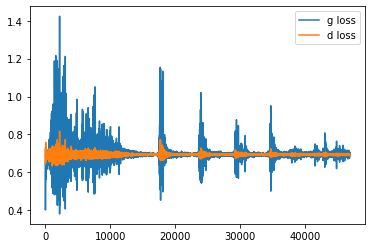

In [72]:
plt.plot(g_losses, label = 'g loss')
plt.plot(d_losses, label = 'd loss')
plt.legend();

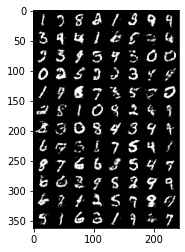

In [73]:
from skimage.io import imread
a = imread('gan_images/50.png')
plt.imshow(a);

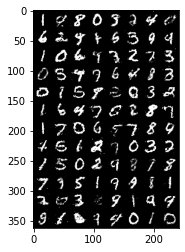

In [74]:
a = imread('gan_images/100.png')
plt.imshow(a);